# Geometric Object Placement Without Depth Estimation (OpenCV + NumPy only)

1. We'll load the foreground object (person)
2. Resize and position it on a background
3. Simulate geometric correctness via manual scaling and positioning

In [41]:
# imports
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [42]:
# directories
ROOT = os.path.dirname(os.getcwd())
RAW_DIR = os.path.join(ROOT, 'data', 'raw')
PROCESSED_DIR = os.path.join(ROOT, 'data', 'processed')

### 1. Load Images

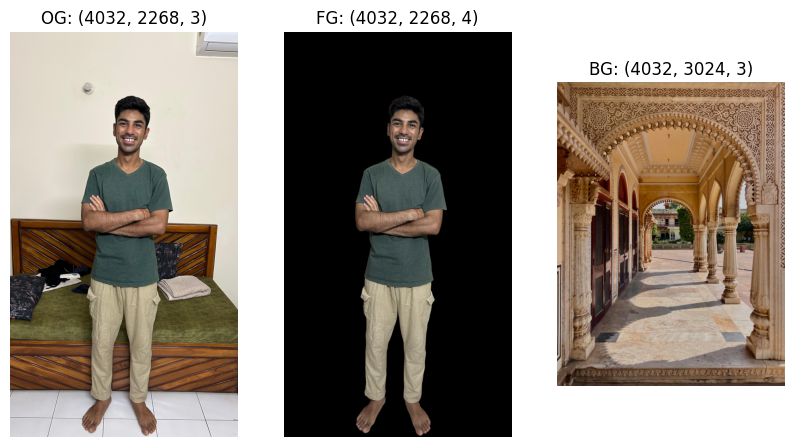

In [43]:
og = cv2.imread(RAW_DIR + '/person.jpeg')[:, :, ::-1]
fg = cv2.imread(PROCESSED_DIR + '/person1_subject.png', cv2.IMREAD_UNCHANGED)
bg = cv2.imread(RAW_DIR + '/bg.jpg')[:, :, ::-1]

fig, axes = plt.subplots(1, 3, figsize = (10, 7))

axes[0].imshow(og)
axes[0].set_title(f'OG: {og.shape}')
axes[0].set_axis_off()

axes[1].imshow(fg[:, :, 2::-1])
axes[1].set_axis_off()
axes[1].set_title(f'FG: {fg.shape}')

axes[2].imshow(bg)
axes[2].set_axis_off()
axes[2].set_title(f'BG: {bg.shape}')

plt.axis('off')
plt.show()

### 2. Extract Alpha Mask and RGB

In [44]:
fg_bgr = fg[:, :, :3]
alpha = fg[:, :, 3] / 255

### 3. Scale the foreground to match perspective

Text(0.5, 1.0, '(1613, 907, 3)')

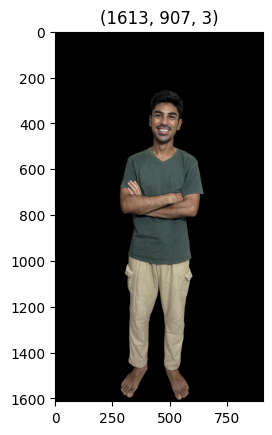

In [45]:
def scale_person(fg_bgr, alpha, scale_factor):
    fg_resized = cv2.resize(fg_bgr, None, fx = scale_factor, fy = scale_factor, interpolation=cv2.INTER_AREA) # shrink image
    alpha_resized = cv2.resize(alpha, (fg_resized.shape[1], fg_resized.shape[0]), interpolation=cv2.INTER_AREA)
    
    return fg_resized, alpha_resized

scaled_fg, scaled_alpha = scale_person(fg_bgr, alpha, scale_factor=0.4)
plt.imshow(scaled_fg[:,:,::-1])
plt.title(scaled_fg.shape)

### 4. Choose placement point on BG

I've chosen it as (1500, 3000) on the BG image and would like to place the feet of the person there.

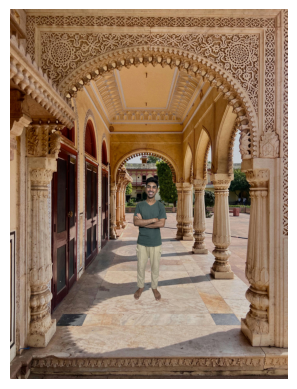

In [46]:
def place_fg_on_bg(bg, scaled_fg, scaled_alpha, point_bg, point_fg):

    x_bg, y_bg = point_bg

    x_fg, y_fg = point_fg

    h_fg, w_fg = scaled_fg.shape[:2]

    x1 = x_bg - x_fg
    x2 = x_bg + w_fg - x_fg

    y1 = y_bg - y_fg
    y2 = y_bg + h_fg - y_fg

    if x1 < 0 or y1 < 0 or x1 > bg.shape[1] or y1 > bg.shape[0] or \
    x2 < 0 or y2 < 0 or x2 > bg.shape[1] or y2> bg.shape[0]:
        print("Foreground image goes out of bound")
        return None

    roi = bg[y1:y2, x1:x2, :]

    scaled_alpha = np.dstack([scaled_alpha]*3)
    
    fin_img = bg.copy()

    fin_img[y1:y2, x1:x2, :] = roi * (1-scaled_alpha) + scaled_fg[:,:,::-1] * scaled_alpha

    plt.imshow(fin_img)
    plt.axis('off')

    return fin_img

h, w = scaled_fg.shape[:2]

H, W = bg.shape[:2]

point = w//2, int(h*0.9)
point_bg = (W//2, int(H*.75))

out_plain = place_fg_on_bg(bg, scaled_fg, scaled_alpha, point_bg, point)

### 5. Warping (Perspective Transformation)

We can go a step further and try to fix the geometry of the person insertion. Since foreground image is taken from a different angle, to make the placement more realistic we need to warp the fg according to the bg.

#### 5.1 Detecting Bounding Boxes

Steps:

* Foreground person A – cropped from one image, with bounding box 
bbox

* Background image containing person B, with bounding box 
bbox

* You want to place person A in the same scene (same scale, orientation, ground alignment) as person B — translated to a new location.



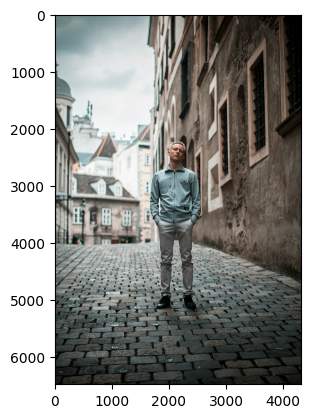

In [7]:
bg_per = cv2.imread(RAW_DIR + '/bg_with_person.jpg')[:,:,::-1]
plt.imshow(bg_per)

In [12]:
# getting bbox of person B (person in the above image)
import sys
sys.path.append(ROOT)
from utils.person_detector import detect_person

bbox_1 = detect_person(RAW_DIR + '/person1.jpg')
bbox_2 = detect_person(RAW_DIR + '/bg_with_person.jpg')

Localizing person using DETR model...
DETR: Detected person with confidence 1.000 at location [691, 637, 1625, 3988]
Localizing person using DETR model...
DETR: Detected person with confidence 1.000 at location [1633, 2216, 2539, 5222]


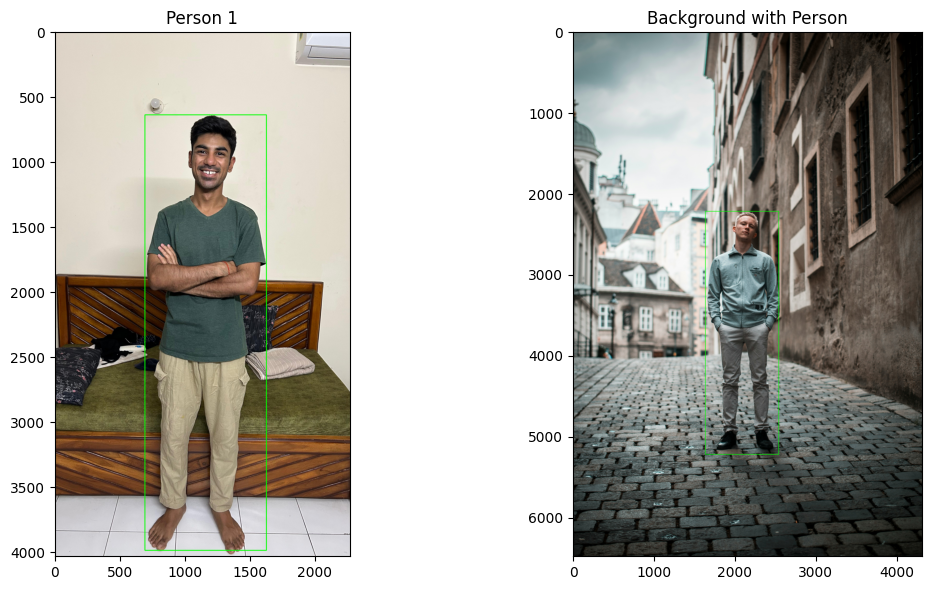

In [13]:
# Draw rectangles around detected persons in both images
bg_per_bbox = bg_per.copy()
person1_bbox = og.copy()

# Draw rectangle for person in background
x_min, y_min, x_max, y_max = bbox_2
cv2.rectangle(bg_per_bbox, (x_min, y_min), (x_max, y_max), (0, 255, 0), 5)

# Draw rectangle for person1
x_min, y_min, x_max, y_max = bbox_1
cv2.rectangle(person1_bbox, (x_min, y_min), (x_max, y_max), (0, 255, 0), 5)

# Display both images side by side
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(person1_bbox)
plt.title('Person 1')
plt.subplot(122)
plt.imshow(bg_per_bbox)
plt.title('Background with Person')
plt.tight_layout()

In [14]:
# TODO: Complete perspective transformation using bboxes

#### 5.2 Selecting points manually

We will select 4 points on the foreground image and 4 points on the previous background image.


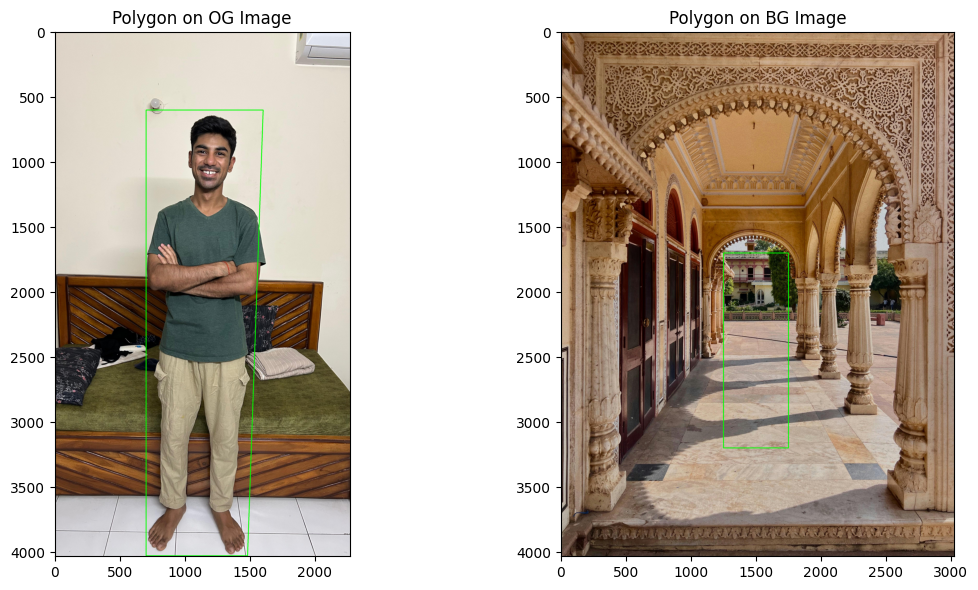

In [64]:
# OG image points
og_points = np.float32([[700, 4030], [1480, 4030], [1600, 600], [700, 600]])

# BG image points
bg_points = np.float32([[1250, 3200], [1750, 3200], [1750, 1700], [1250, 1700]])

# Visualize points on images
og_poly = og.copy()
cv2.polylines(og_poly, [og_points.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=5)

bg_poly = bg.copy()
cv2.polylines(bg_poly, [bg_points.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=5)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(og_poly)
plt.title('Polygon on OG Image')
plt.subplot(122)
plt.imshow(bg_poly)
plt.title('Polygon on BG Image')
plt.tight_layout()
plt.show()

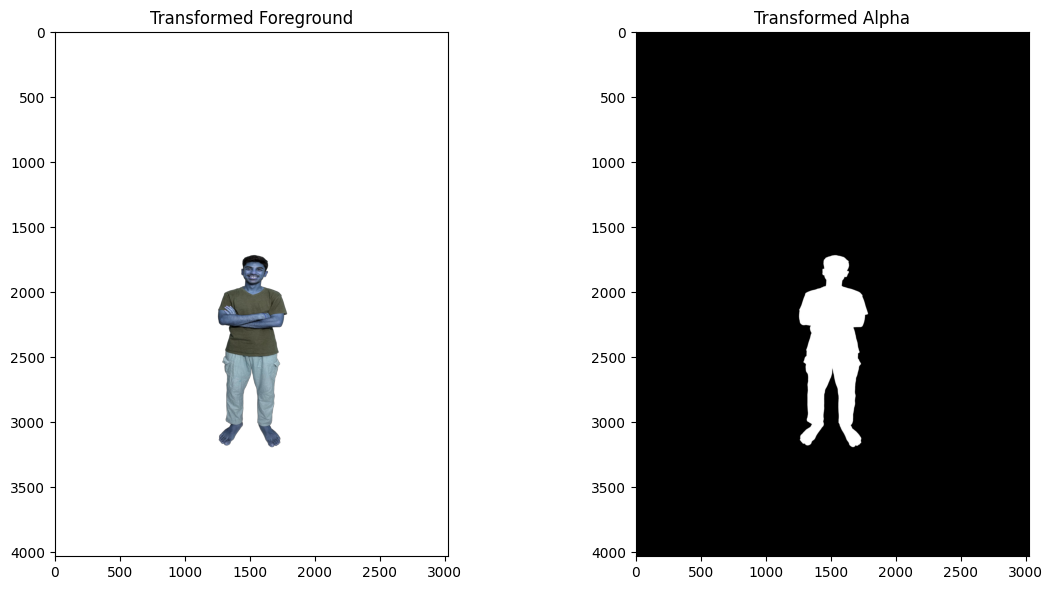

In [65]:
# Calculate perspective transform matrix
matrix = cv2.getPerspectiveTransform(og_points, bg_points)

# Apply transformation to foreground and alpha
transformed_fg = cv2.warpPerspective(fg, matrix, (bg.shape[1], bg.shape[0]))
transformed_alpha = cv2.warpPerspective(alpha, matrix, (bg.shape[1], bg.shape[0]))

# Display transformed results
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(transformed_fg)
plt.title('Transformed Foreground')
plt.subplot(122)
plt.imshow(transformed_alpha, cmap='gray')
plt.title('Transformed Alpha')
plt.tight_layout()
plt.show()

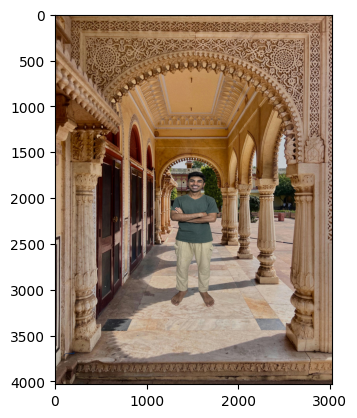

In [66]:
alpha_ext = np.dstack([transformed_alpha]*3)
fin_img = transformed_fg[:,:,2::-1]*alpha_ext+ bg*(1-alpha_ext)

plt.imshow(fin_img/255)
plt.show()